In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage.io
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [24]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = 'Greys')
    plt.show()
    
palette ={ 0 :(255, 255, 168), #2.1.1 Non-irrigated arable land ## 211
           1 : (77, 255, 0),  #3.1.3 Mixed forest
           2 : (230, 128, 0), #2.2 Permanent crops ### 221
           3 : (255, 0, 0),  #1.1.2 Discontinuous urban fabric## 112
           4 : (0,0, 0), #No Data
         }
invert_palette = {v: k for k, v in palette.items()}


def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# helper function for data visualization
def visualize_in_one_row(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
DATA_DIR = r"C:\Users\CBS-7\Desktop\aerial_new_edits\classEditForDL\water_road_hetero_class_Edits\Dataset"

x_train_dir = os.path.join(DATA_DIR, 'Train', 'Image')
y_train_dir = os.path.join(DATA_DIR, 'Train', 'Mask')

x_valid_dir = os.path.join(DATA_DIR, 'Val', 'Image')
y_valid_dir = os.path.join(DATA_DIR, 'Val', 'Mask')

x_test_dir = os.path.join(DATA_DIR, 'Test', 'Image')
y_test_dir = os.path.join(DATA_DIR, 'Test', 'Mask')

In [4]:
class Dataset(BaseDataset):
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
    ):
        self.ids = os.listdir(images_dir)
        self.mask_ids = os.listdir(masks_dir)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.mask_ids]
        
        self.class_values = np.asarray([0,1,2,3,4])
        
    @staticmethod
    def _read_img(image_path):
        img = skimage.io.imread(image_path, plugin='tifffile')
        return img

    def __getitem__(self, i):
        
        # read data
        im_id = self.images_fps[i].split('\\')[-1]
        
        image = self._read_img(self.images_fps[i])
        mask =  self._read_img(self.masks_fps[i])
 
        mask_raw = convert_from_color(mask)
        
        masks = [(mask_raw == v) for v in self.class_values]

        maskx = np.stack(masks, axis=-1)      

        image = np.expand_dims(image,axis = -1)
        image = image.transpose(2, 0, 1).astype('float32') #
        maskxx = maskx.transpose(2, 0, 1).astype('float32')
        
        image = torch.as_tensor(image, dtype=torch.float32).cuda()
        mask_ = torch.as_tensor(maskxx, dtype=torch.float32).cuda()   

        return image, mask_
        
    def __len__(self):
        return len(self.ids)

[0 2 3]
255.0


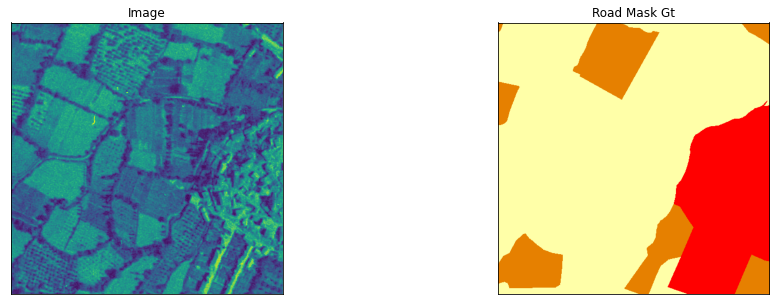

[0 1 2 4]
255.0


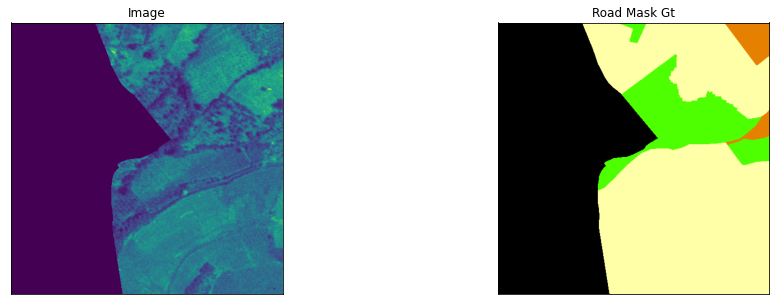

[0 1 4]
255.0


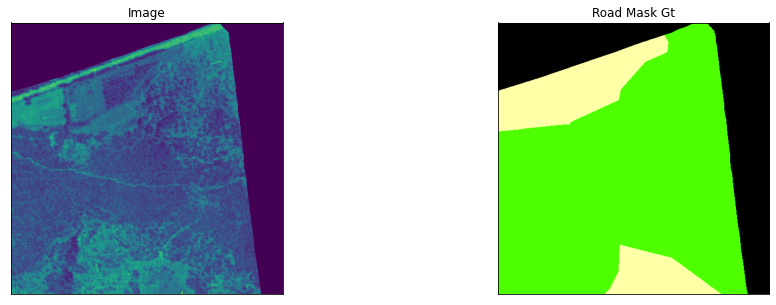

[0 1 4]
253.0


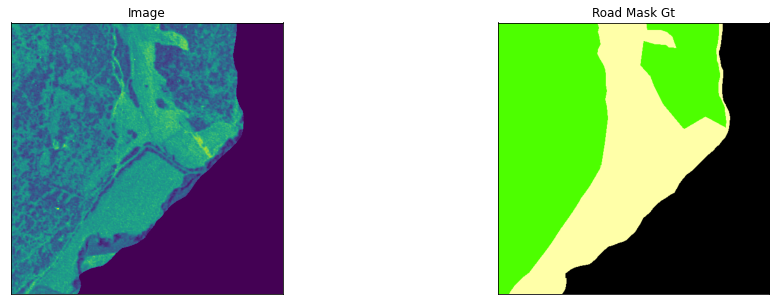

[0 1]
255.0


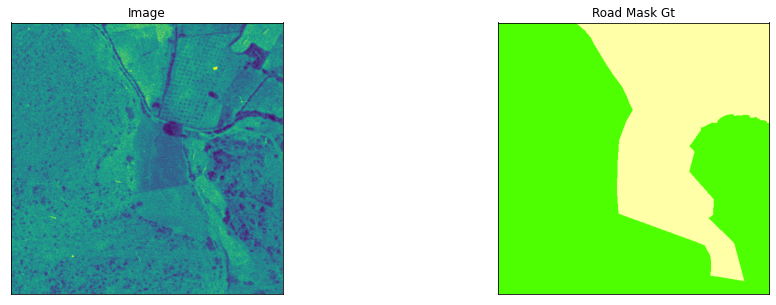

[0 1 4]
255.0


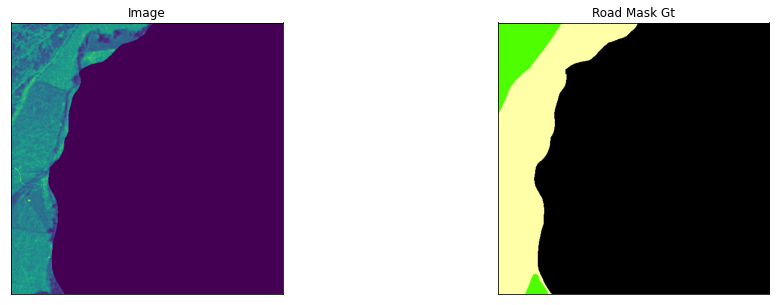

[0 1 4]
250.0


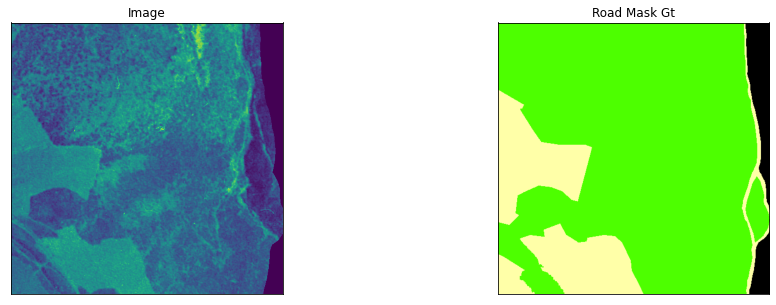

[0 2 4]
233.0


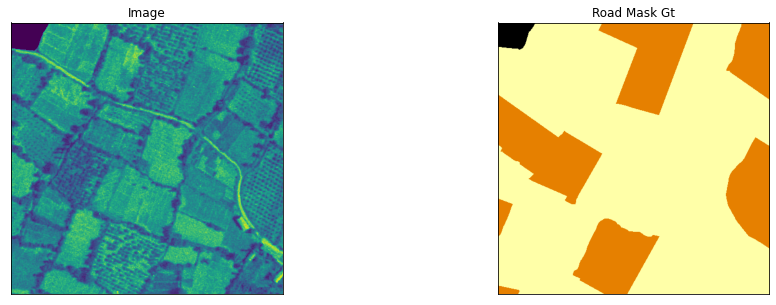

[0 1]
255.0


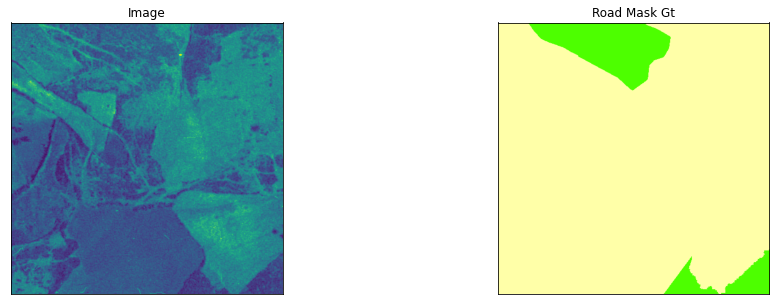

[0 2]
255.0


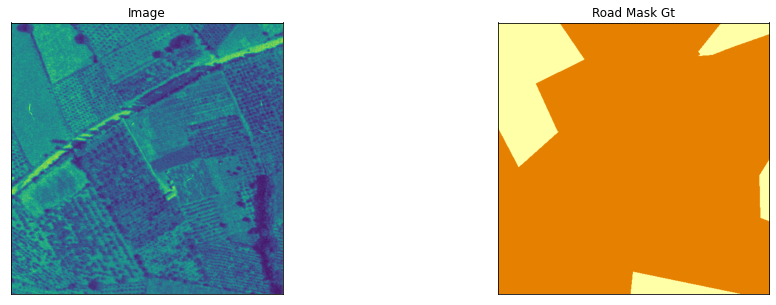

In [5]:
for i in range(10):
    
    dataset = Dataset(x_train_dir, y_train_dir)

    image, mask = dataset[np.random.randint(len(dataset))] # get some sample

    image = image.detach().cpu().numpy()
    image[image == 65536] = 0 
    mask  = mask.detach().cpu().numpy()

    image = np.transpose(image, (1,2,0))
    mask = np.transpose(mask, (1,2,0))
    mask = np.argmax(mask, axis = 2)
    print(np.unique(mask))
    print(image.max())
    mask = convert_to_color(mask)
   # print(mask)

    visualize(
        image=image, 
        road_mask_GT =mask)

In [6]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        #albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.RandomCrop(height=256, width=256, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
            ],
            p=0.9,
        ),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.RandomCrop(height=256, width=256, always_apply=True),
    ]
    return albu.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
    ]
    return albu.Compose(_transform)

In [7]:
ENCODER = 'resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = len(palette)
ACTIVATION = 'softmax' 
DEVICE = 'cuda'

model = smp.DeepLabV3Plus(
                encoder_name=ENCODER, 
                encoder_weights= 'imagenet', 
                classes=CLASSES, 
                activation=ACTIVATION,
                in_channels = 1)

log_path = r"C:\Users\CBS-7\Desktop\aerial_new_edits\classEditForDL\water_road_hetero_class_Edits\output_files"
experiment_log = r"resnext50_32x4d_DLV3plus_0"

In [8]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 

)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 

)

In [9]:
from sklearn.utils import compute_sample_weight
from pytorch_toolbelt.utils import fs
from torch.utils.data import WeightedRandomSampler

def get_balanced_weights(dataset):
    labels=[]
    for mask in dataset.masks_fps:
      mask = fs.read_image_as_is(mask)
      unique_labels = np.unique(mask)
      labels.append(''.join([str(int(i)) for i in unique_labels]))

    weights = compute_sample_weight('balanced', labels)
    return weights

In [10]:
mul_factor =  10
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * mul_factor)
val_sampler = WeightedRandomSampler(get_balanced_weights(valid_dataset), len(valid_dataset) * mul_factor)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=4, sampler = train_sampler, drop_last= True)
valid_loader = DataLoader(valid_dataset, batch_size=4, sampler = val_sampler, drop_last = True)

In [12]:
loss = smp.utils.losses.DiceLoss()

metrics = [smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [13]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, os.path.join(log_path, '.\{}.pth'.format(experiment_log)))
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [14]:
best_model = torch.load(os.path.join(log_path, '.\{}.pth'.format(experiment_log)))

In [15]:
best_model.modules

<bound method Module.modules of DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): R

In [16]:
best_model.cuda()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [17]:
# create test dataset
test_dataset = Dataset(
    x_test_dir,
    y_test_dir,
)

test_dataloader = DataLoader(test_dataset)

In [18]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid:  18%|▏| 3/17 [00:01<00:04,  3.36it/s, dice_loss - 0.0574, accuracy - 0.9771, iou_score - 0.8967, fscore - 0.9427

C:\Users\CBS-7\anaconda3\envs\pgpu\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|█| 17/17 [00:01<00:00,  8.73it/s, dice_loss - 0.05153, accuracy - 0.9799, iou_score - 0.9063, fscore - 0.94


In [25]:
logs

{'dice_loss': 0.05152616781346939,
 'accuracy': 0.9798987157204573,
 'iou_score': 0.9063283906263464,
 'fscore': 0.949707311742446,
 'precision': 0.9502713820513556,
 'recall': 0.9491451487821692}

<ipython-input-27-6d6a46decf3f>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
<ipython-input-27-6d6a46decf3f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor, device = 'cuda')


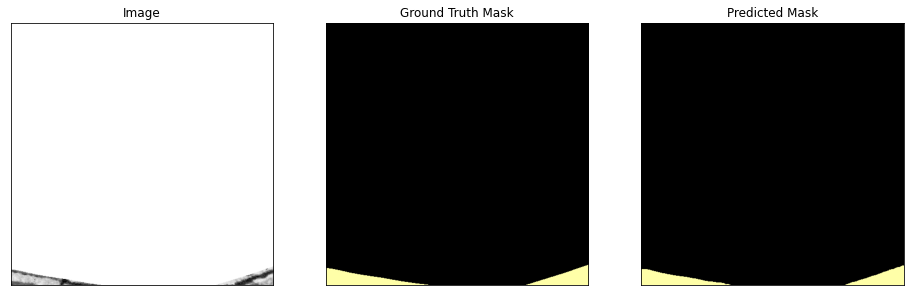

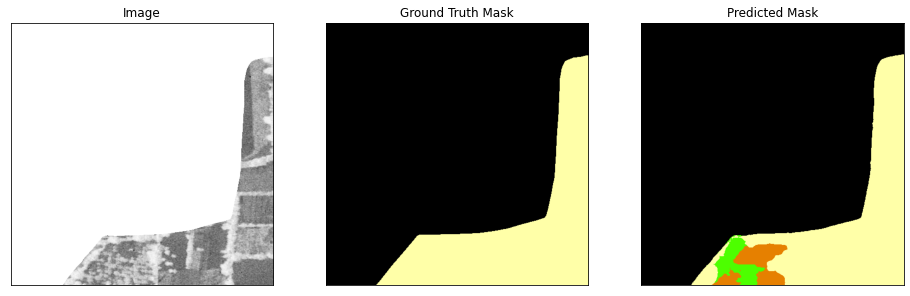

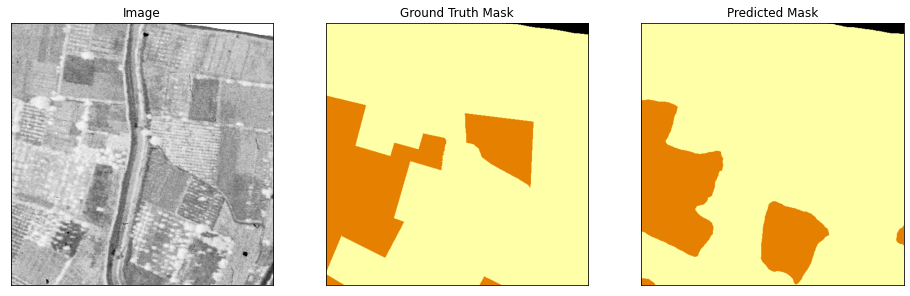

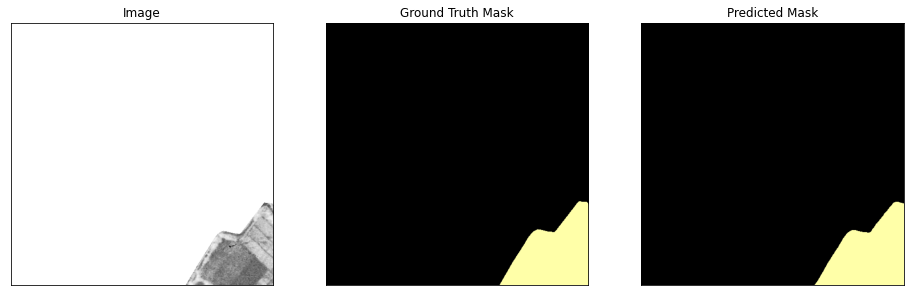

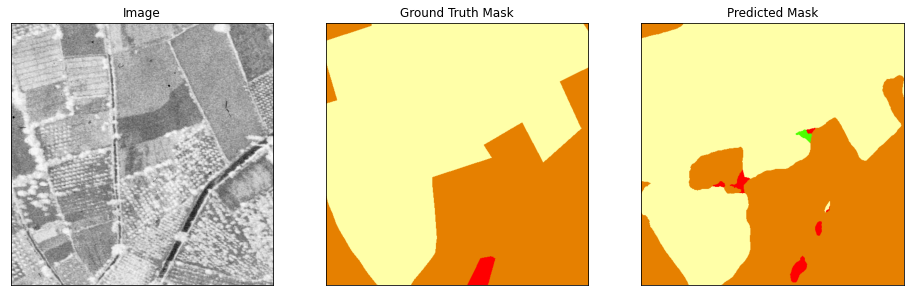

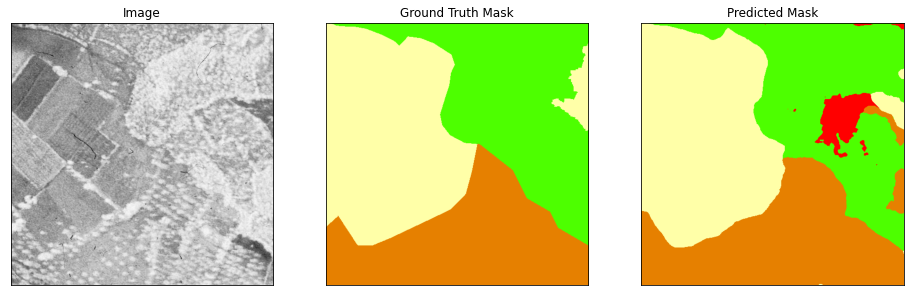

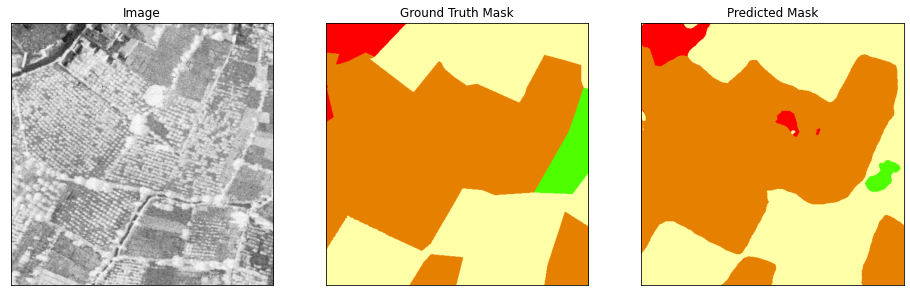

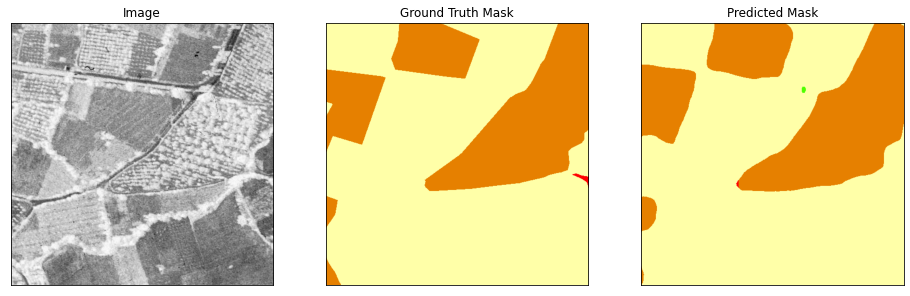

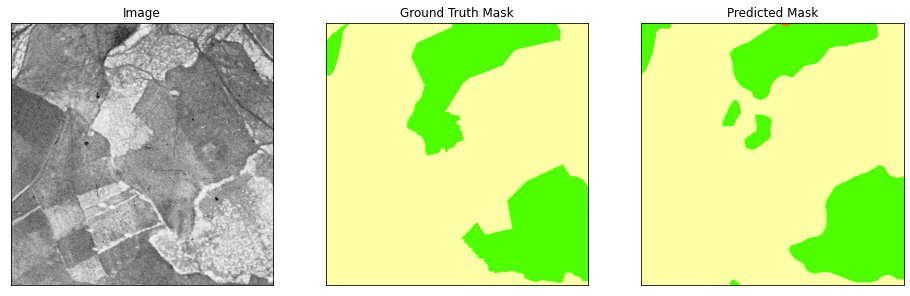

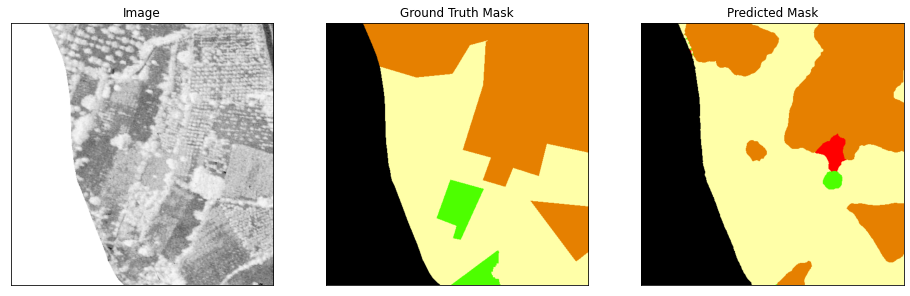

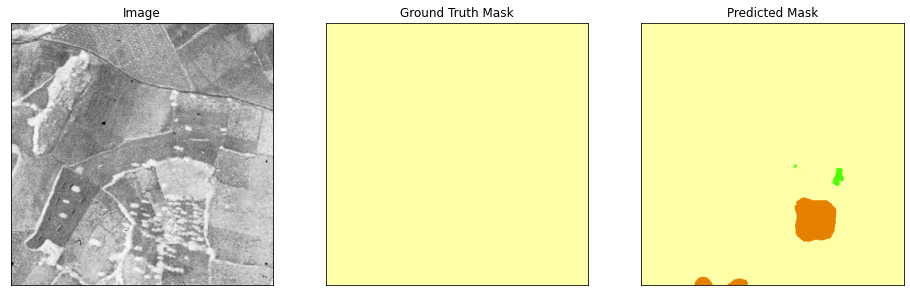

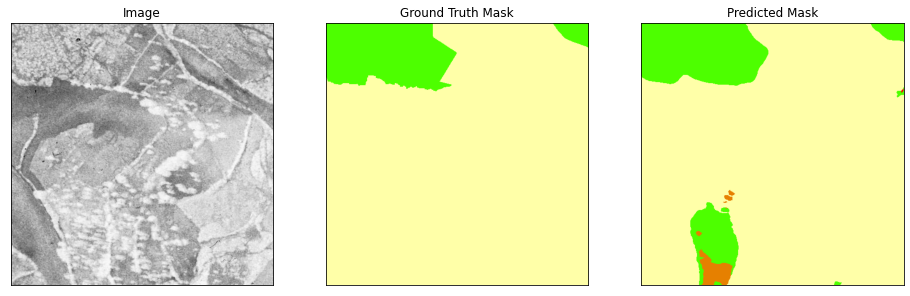

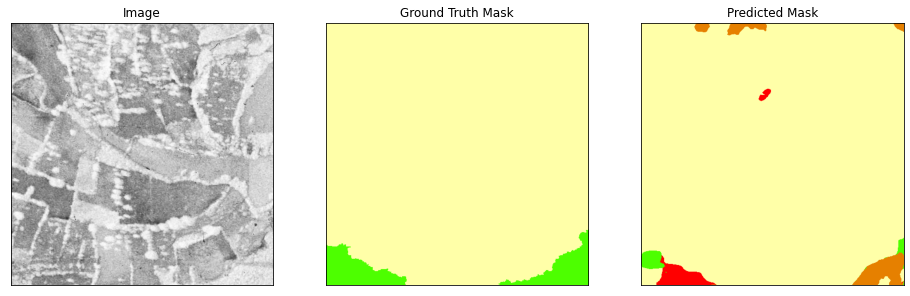

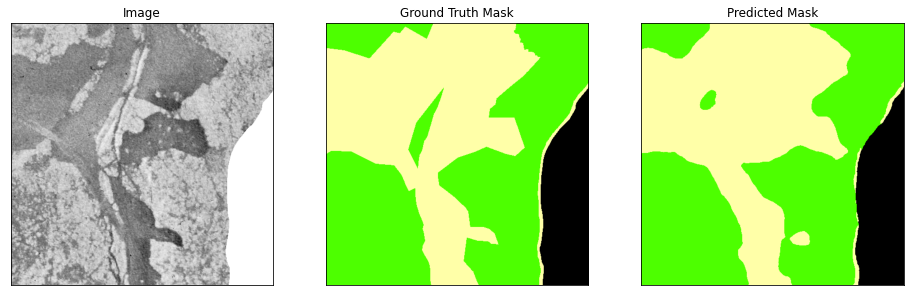

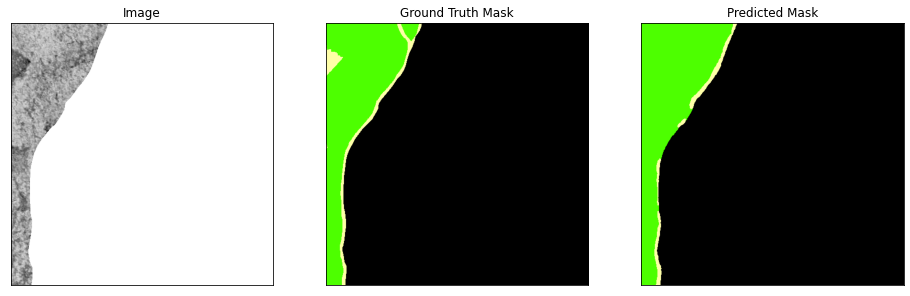

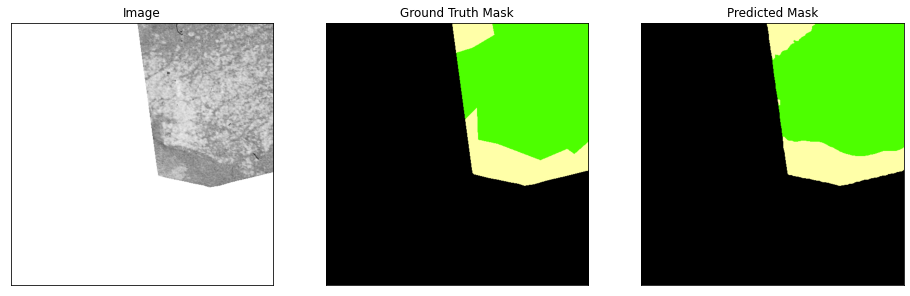

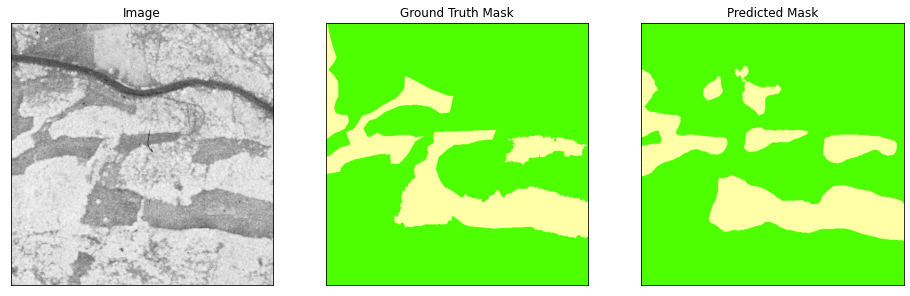

IndexError: list index out of range

In [27]:
for i in range(20):
        
    image, mask = test_dataset[i] # get some sample
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1,2,0))
    image[image == 65536] = 0 

    
    gt_mask = np.transpose(test_dataset[i][1].detach().cpu().numpy(),(1,2,0))
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)    

    x_tensor = test_dataset[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float() 
    tensor = torch.tensor(tensor, device = 'cuda')

    pr_mask = best_model.predict(tensor).detach().cpu().numpy()
    pr_max  = np.argmax(pr_mask, 1)
    pr_max = np.transpose(pr_max, (1,2,0)).squeeze()
    
    pr_max11 = convert_to_color(pr_max)

    visualize(
            image=image,  #ımage torch.Size([512, 512, 4])
            ground_truth_mask=gt_color,  #gt_color (512, 512, 3)
            predicted_mask=pr_max11) #pr_max11 (512, 512, 3)

In [ ]:
def evaluate(model, generator):
    """ usage:
        from sklearn.metrics import classification_report
        y_pred, y = evaluate(best_model, generator)
        y_pred  = np.hstack(y_pred)
        y = np.hstack(y)
        targets = ['building', 'not_building']
        print(classification_report(y, y_pred, target_names = targets))#, output_dict = True)
    """
    
    best_model = model
    best_model.cuda()
    best_model.eval()

    y_preds = list()
    ys = list()
    with torch.no_grad():
        for idx in tqdm.tqdm(range(len(generator))):
            X,y = generator[idx]
            #X = X.detach().cpu().numpy()
            y = y.detach().cpu().numpy()
            gt_max = np.argmax(y, axis=0)
            #gt_colora = convert_to_color(gt_max)
            logsoftmax = best_model.forward(X[None,:,:])
            y_pred = logsoftmax.argmax(dim=1)
            y_pred = y_pred.squeeze()
            gt_color = torch.as_tensor(gt_max).cuda()
            gt_color = gt_color.detach().cpu().numpy().flatten()
            y= gt_color 
            y_pred = y_pred.flatten().detach().cpu().numpy()
            
            ys.append(y)
            y_preds.append(y_pred)
            
    best_model.cpu()
    return y_preds, ys    

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

import tqdm

In [ ]:
y_preds, ys = evaluate(best_model, test_dataset)

In [ ]:
y_preds = np.asarray(y_preds)
ys = np.asarray(ys)

F1 = f1_score(ys.flatten(), y_preds.flatten(), average=None)
Precision = precision_score(ys.flatten(), y_preds.flatten(), average=None)
Recall = recall_score(ys.flatten(), y_preds.flatten(), average=None)
a = (F1.flatten(), Precision.flatten(), Recall.flatten())
jacc = jaccard_score(ys.flatten(), y_preds.flatten(), average = None)
f1 = np.asarray(F1)
prec = np.asarray(Precision)
rec = np.asarray(Recall)
jac = np.asarray(jacc)

metrics = np.stack((f1, prec, rec,jac), axis = 1)
metrics

In [ ]:
f1.mean()

In [ ]:
prec.mean()

In [ ]:
rec.mean()

In [ ]:
jac.mean()

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib 
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix 

def plot_confusion_matrix(ys,
                          y_preds,
                          classes,
                          normalize=False,
                          cmap=plt.cm.Greys):

    params = {'font.size': 22,
              'xtick.labelsize':27,
              'ytick.labelsize':27}
    matplotlib.rcParams.update(params)

    cm = confusion_matrix(ys.flatten(), y_preds.flatten())

    if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
           
    fig, ax = plt.subplots(figsize=(30, 30))

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, origin = 'upper') 
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes)
           #ylabel='True label',
           #xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.tight_layout()
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] == 0.:
                continue
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.savefig('Confusion-NWPU_enumerated_FINAL.svg', pad_inches = 0, transparent=False, bbox_inches='tight')
    return ax

In [ ]:
Class_names = ['Arable Land',
               'Mixed Forest',
               'Permenant Crops',
               'Discont Urban Fabric',
               'NoData',
               ] 

In [ ]:
np.unique(ys)

In [ ]:
np.unique(y_preds)

In [ ]:
plot_confusion_matrix(ys=ys,
                      y_preds=y_preds,
                      classes=Class_names,
                      normalize=True)